In [1]:
import os
import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import join

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle
from collections import Counter

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import to_categorical

import librosa
import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

import matplotlib.pyplot as plt
%matplotlib inline 
import scikitplot as skplt

def generator(features, labels, batch_size):
    while True:
        batch_features = []
        batch_labels = []
        
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features.extend(features[index])
            batch_labels.extend(labels[index])
        batch_features = np.array(batch_features)
        batch_labels = np.array(batch_labels)
        yield batch_features, batch_labels    

Using TensorFlow backend.


In [2]:
AUDIO_PATH = '../genres/'
classes_temp = os.walk(AUDIO_PATH).__next__()[1] ## Finds the number of classes

In [3]:
load = True
split_num = 80 ## Number of songs on train per class
savename = "offseti2-duration2.npy"

if load:    
    list_data_train = np.load("list_data_train-" + savename)
    classes_train = np.load("classes_train-" + savename)
    list_data_test = np.load("list_data_test-" + savename)
    classes_test = np.load("classes_test-" + savename)
    
else:
    list_data = [] 
    classes = []
    for c in tqdm(classes_temp):
        for root, subdirs, files in os.walk(os.path.join(AUDIO_PATH, c)):
            for file in files[:split_num]:
                for i in range(0, 20, 2):
                    filepath = os.path.join(root, file)    
                    wavedata, samplerate = librosa.load(filepath, mono=True, offset=i, duration=2)    
                    wavedata = wavedata[np.newaxis, :]
                    list_data.append(wavedata)
                    classes.append(c)

    np.save("list_data_train-" + savename, list_data)
    np.save("classes_train-" + savename, classes)
    
    list_data = [] 
    classes = []
    for c in tqdm(classes_temp):
        for root, subdirs, files in os.walk(os.path.join(AUDIO_PATH, c)):
            for file in files[split_num:]:
                for i in range(0, 20, 2):
                    filepath = os.path.join(root, file)    
                    wavedata, samplerate = librosa.load(filepath, mono=True, offset=i, duration=2)    
                    wavedata = wavedata[np.newaxis, :]
                    list_data.append(wavedata)
                    classes.append(c)

    np.save("list_data_test-" + savename, list_data)
    np.save("classes_test-" + savename, classes)

In [4]:
print('Train Shape',list_data_train.shape)
print('Test Shape',list_data_test.shape)

Train Shape (8000, 1, 44100)
Test Shape (2000, 1, 44100)


In [5]:
labelencoder = LabelEncoder()
labelencoder.fit(classes_train)
n_classes = len(labelencoder.classes_)
print(n_classes, "classes:", ", ".join(list(labelencoder.classes_)))
classes_num_train = labelencoder.transform(classes_train)
classes_num_test = labelencoder.transform(classes_test)

10 classes: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock


In [6]:
classes_num_1hot = to_categorical(classes_num_train)
print('Train classes shape:',classes_num_1hot.shape)

Train classes shape: (8000, 10)


In [7]:
# testset_size = 0.25
# splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
# splits = splitter.split(data, classes_num)

In [8]:
# for train_index, test_index in splits:
#     print("TRAIN INDEX:", train_index)
#     print("TEST INDEX:", test_index)
    
#     train_set = data[train_index]
#     test_set = data[test_index]
    
#     train_classes = classes_num[train_index]
#     train_classes_1hot = classes_num_1hot[train_index]
#     test_classes = classes_num[test_index]

# print(train_set.shape)
# print(test_set.shape)

In [9]:
list_data_train, classes_num_1hot  = shuffle(list_data_train, classes_num_1hot, random_state=0)
list_data_test, classes_num_test  = shuffle(list_data_test, classes_num_test, random_state=0)

print(list_data_train.shape)
print(list_data_test.shape)

(8000, 1, 44100)
(2000, 1, 44100)


In [10]:
cnt = Counter(classes_num_train)
print("Number of files in each category in TRAIN set:")
for k in sorted(cnt.keys()):
    print(k, ":", cnt[k])

Number of files in each category in TRAIN set:
0 : 800
1 : 800
2 : 800
3 : 800
4 : 800
5 : 800
6 : 800
7 : 800
8 : 800
9 : 800


In [11]:
input_shape = list_data_train.shape[1:]  
input_shape

(1, 44100)

In [12]:
np.random.seed(0)
loadModel = None
loadModel = False
modelName = "model1-conv2d"

if loadModel:
    model = keras.models.load_model(modelName + ".h5", custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                                       'Normalization2D': kapre.utils.Normalization2D})
    history = np.load(modelName + "-history.npy").item()
else:
    model = Sequential()
    model.add(Melspectrogram(n_dft=1024, n_hop=512, input_shape=input_shape, return_decibel_melgram=True, trainable_fb=False, name='melgram'))
    model.add(Normalization2D(str_axis='freq'))
    
    # Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    # Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 3
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(Dense(100, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dense(n_classes,activation='softmax'))
    
    model.layers[0].trainable = False
    model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['accuracy'])
    history = None
    
model.summary()

tracking <tf.Variable 'melgram/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'melgram/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'melgram/Variable:0' shape=(513, 128) dtype=float32> freq2mel
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 87, 1)        1116288   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 128, 87, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 85, 32)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 85, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2

In [13]:
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto')
History = model.fit(list_data_train, classes_num_1hot, validation_split=0.1, batch_size=32, epochs=25)

if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])
        
model.save(modelName + ".h5")
np.save(modelName + "-history.npy", history)

Train on 7200 samples, validate on 800 samples
Epoch 1/25
7200/7200 [==============================] - 20s 3ms/step - loss: 1.4245 - accuracy: 0.5043 - val_loss: 2.4013 - val_accuracy: 0.2812
Epoch 2/25
7200/7200 [==============================] - 19s 3ms/step - loss: 0.9339 - accuracy: 0.6856 - val_loss: 1.2293 - val_accuracy: 0.5738
Epoch 3/25
7200/7200 [==============================] - 18s 2ms/step - loss: 0.7611 - accuracy: 0.7499 - val_loss: 1.0338 - val_accuracy: 0.6587
Epoch 4/25
7200/7200 [==============================] - 17s 2ms/step - loss: 0.6197 - accuracy: 0.8007 - val_loss: 0.9732 - val_accuracy: 0.6675
Epoch 5/25
7200/7200 [==============================] - 17s 2ms/step - loss: 0.5039 - accuracy: 0.8386 - val_loss: 0.9288 - val_accuracy: 0.7025
Epoch 6/25
7200/7200 [==============================] - 18s 2ms/step - loss: 0.3994 - accuracy: 0.8844 - val_loss: 0.9093 - val_accuracy: 0.7163
Epoch 7/25
7200/7200 [==============================] - 19s 3ms/step - loss: 0.3297

In [14]:
def plot_traincurve(history):
    colors = {'loss':'r', 'accuracy':'b', 'val_loss':'m', 'val_accuracy':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")
    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line
    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

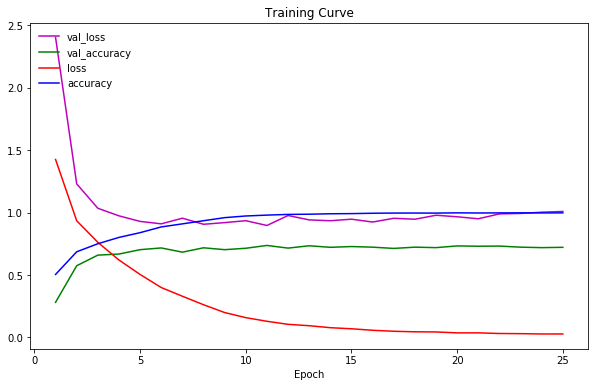

In [15]:
plot_traincurve(history)

In [16]:
test_pred = model.predict_classes(list_data_test, verbose=1)
test_proba = model.predict_proba(list_data_test, verbose=1)

2000/2000 [==============================] - 2s 955us/step


In [17]:
accuracy_score(classes_num_test, test_pred)

0.694

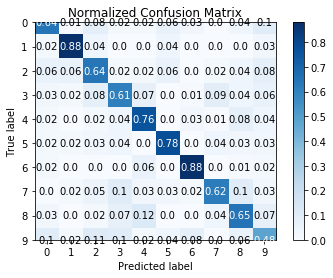

In [18]:
skplt.metrics.plot_confusion_matrix(classes_num_test, test_pred, normalize=True)
plt.show()

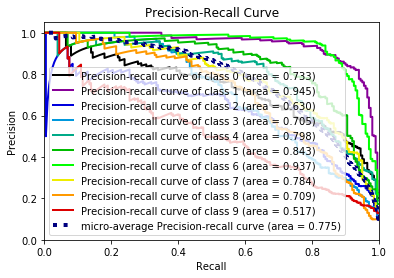

In [19]:
skplt.metrics.plot_precision_recall(classes_num_test, test_proba)
plt.show()

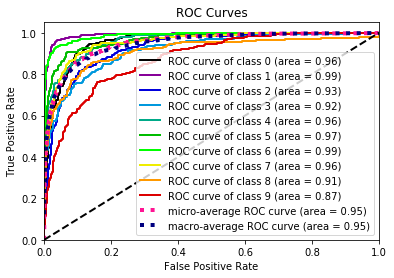

In [20]:
skplt.metrics.plot_roc(classes_num_test, test_proba)
plt.show()